# Assignment 2.2 Convolutional network

In [151]:
import os
import numpy as np
import skimage
from skimage import io, transform, color, filters, data, morphology, measure
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    images_name = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            images_name.append(filename[0:4])
    
    images_df = pd.DataFrame({"name": images_name,
                             "image": images})
    return images_df

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    
    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

De hierboven gedefineerde functies zijn geleverd door Saxion zelf. Die zullen gebruikt worden voor het inladen van de data en het tonen van de afbeeldingen.

Hieronden wordt de data ingeladen. Voor de zekerheid zullen we de data ook printen.

In [152]:
all_images_df = load_images_from_folder('./dataset-images')
all_images_df

,name,image
0,1000,"[[[241, 241, 241], [242, 242, 242], [244, 244,..."
1,1027,"[[[206, 206, 206], [211, 211, 211], [218, 218,..."
2,1029,"[[[82, 82, 82], [83, 83, 83], [84, 84, 84], [8..."
3,1036,"[[[241, 241, 241], [246, 246, 246], [243, 243,..."
4,1053,"[[[241, 241, 241], [243, 243, 243], [243, 243,..."
...,...,...
475,9867,"[[[231, 231, 231], [227, 227, 227], [225, 225,..."
476,9909,"[[[77, 77, 77], [74, 74, 74], [78, 78, 78], [7..."
477,9923,"[[[116, 116, 116], [114, 114, 114], [113, 113,..."
478,9954,"[[[105, 105, 105], [102, 102, 102], [110, 110,..."


Zoals hierboven is te zien is de data succesvol geladen. Laten we voor de zekerheid kijken of er toch geen gebreken zijn. Hiervoor zullen we de "describe()" functie gebruiken.

In [153]:
all_images_df.describe()

,name,image
count,480,480
unique,480,480
top,5578,"[[[148, 148, 148], [158, 158, 158], [148, 148,..."
freq,1,1


Voor nu lijkt de data in orde dus kunnen we verder gaan.

De data is nu verzameld.

Om de data te kunnen gebruiken voor de machine learning algoritme zullen we het eerst moeten preprocessen en de features eruit halen.

Hieronder zullen we een begin maken met het schrijven van de eerste versie van de preproces pipeline. Hiervoor zullen we de volgende stappen uitvoeren:

1. De kleuren van de afbeelding omdraaien, zodat de cijfers wit zijn en de achtergrond zwart.
2. De afbeelding omzetten naar een binair formaat (zwart/wit).
3. Afbeelding knippen naar 1 cijfer per afbeelding.
4. Afbeelding plaatsen in een grid en features eruit halen.

## De kleuren van de afbeelding omdraaien, zodat de cijfers wit zijn en de achtergrond zwart.

In [154]:
image = all_images_df.iloc[0,1]
image_name = all_images_df.iloc[0,0]

image = image*-1

## De afbeelding omzetten naar een binair formaat (zwart/wit).

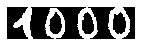

In [155]:
gray = color.rgb2gray(image)
thresh = filters.threshold_otsu(gray)
binary = gray > thresh
display(binary)

In [156]:
def initialize_image(image, image_name):
    zipcode = image
    zipcode = zipcode *-1
    gray = color.rgb2gray(zipcode)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    binary_splitted = [binary[:, :32], binary[:, 32:64], binary[:, 64:96], binary[:, 96:128]]
    
    df = pd.DataFrame(columns=['feature', 'number'])
    
    for x in range(0, 4):
        df.loc[x, 'number'] = image_name[x]
        df.loc[x, 'feature'] = binary_splitted[x]
    
    return df
    
result = pd.DataFrame()

for i in range(0, len(all_images_df.index)):
    image_name = all_images_df.iloc[i,0]
    image = all_images_df.iloc[i,1]
    tmp_result = initialize_image(image, image_name)
    result = pd.concat([result, tmp_result])
    
result.reset_index(inplace=True)
result.drop(columns=['index'], inplace=True)
result

,feature,number
0,"[[False, False, False, False, False, False, Fa...",1
1,"[[False, False, False, False, False, False, Fa...",0
2,"[[False, False, False, False, False, False, Fa...",0
3,"[[False, False, False, False, False, False, Fa...",0
4,"[[False, False, False, False, False, False, Fa...",1
...,...,...
1915,"[[False, False, False, False, False, False, Fa...",4
1916,"[[False, True, False, False, False, True, Fals...",9
1917,"[[False, False, False, False, False, False, Fa...",9
1918,"[[False, False, False, False, True, False, Fal...",9


Nu we de afbeeldingen hebben omgezet, kunnen we allereerst de splitsen

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        result['feature'], result['number'], test_size=0.1, random_state=28)


In [158]:
len(X_train)

1728

In [159]:
len(X_test)

192

In [160]:
#reshape data to fit model
#X_train_reshaped = X_train.to_numpy().reshape(1728,32,32,1)
#X_test_reshaped = X_test.to_numpy().reshape(192,32,32,1)

In [161]:
from keras.utils import to_categorical
#one-hot encode target column
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_train_encoded[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [215]:
tt = np.vstack(X_train)
X_train = tt.reshape(len(X_train),32,32)
rr = np.vstack(X_test)
X_test = rr.reshape(len(X_test),32,32)

De data is nu klaar. we moeten we alleen de structuur van de data veranderen zodat het voldoet aan de verwachte input van het neurale netwerk.

In [224]:
#reshape data to fit model
X_train = X_train.reshape(len(X_train),32,32,1)
X_test = X_test.reshape(len(X_test),32,32,1)
X_train.shape

(1728, 32, 32, 1)

In [225]:
X_test.shape

(192, 32, 32, 1)

In [236]:
y_train_encoded[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
bb = np.vstack(y_train)
X_train = bb.reshape(len(X_train),10,1)
cc = np.vstack(X_test)
X_test = cc.reshape(len(X_test),10,1)

In [249]:
y_train.shape

(1728,)

Nu kunnen we het neurale netwerk bouwen. Daarin geven we de structuur van de input aan, wat in ons geval (32,32,1) is. Daarnaast zal de output layer bestaan uit 10 nodes, omdat het getal tussen de reeks van [0-9] zit.

Voor de output layer zal er gebruik gemaakt worden van Softmax. Softmax wordt namelijk gebruikt voor classificatie problemen

In [271]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = None
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [272]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Nu het neurale netwerk is opgezet kunnen we beginnen met de eerste training

In [273]:
#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 5s 90ms/step - loss: 1.0619 - accuracy: 0.6619 - val_loss: 0.2623 - val_accuracy: 0.9422
Epoch 2/3
49/49 [==============================] - 4s 84ms/step - loss: 0.1002 - accuracy: 0.9672 - val_loss: 0.2235 - val_accuracy: 0.9538
Epoch 3/3
49/49 [==============================] - 4s 81ms/step - loss: 0.0465 - accuracy: 0.9877 - val_loss: 0.3213 - val_accuracy: 0.9306


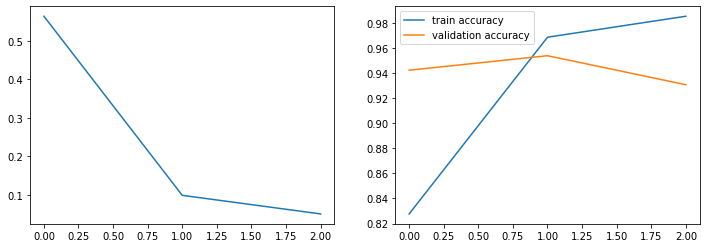

In [274]:
from matplotlib import pyplot
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

Kijkend naar de eerste resultaten lijkt het neurale netwerk aardig goed te presteren. De loss zit ook zeer laag. Met een kleine aantal epochs zit de accuraatheid hoog. De validatie accuraatheid zit ook in de buurt van de train accuraatheid. Dus het lijkt niet veel last te hebben van overfitting.

Het idee is om nu 5 andere neurale netwerken te creeeren om te experimenteren hoe de overige modellen presteren.

## Netwerk 2

In [277]:
#create model
model = None
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model2.add(Dense(10, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 5s 89ms/step - loss: 1.1039 - accuracy: 0.6520 - val_loss: 0.3302 - val_accuracy: 0.9191
Epoch 2/3
49/49 [==============================] - 4s 83ms/step - loss: 0.1425 - accuracy: 0.9526 - val_loss: 0.2587 - val_accuracy: 0.9364
Epoch 3/3
49/49 [==============================] - 4s 86ms/step - loss: 0.0664 - accuracy: 0.9805 - val_loss: 0.2745 - val_accuracy: 0.9422


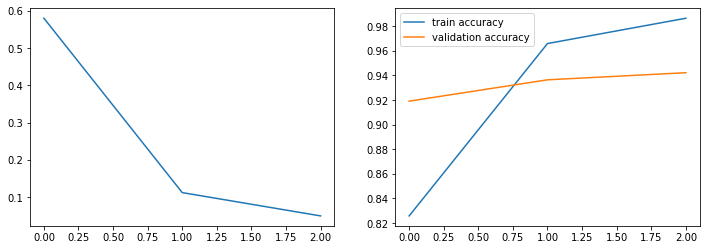

In [278]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

de resultaten van netwerk 2 is eigenlijk vergelijkbaar met netwerk 1. De validatie accuraatheid heeft alleen geen dalende lijn. Het toevoegen van een extra layer lijkt toch niet veel verschil te maken.

## Netwerk 3

In [ ]:
#create model
model = None
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model2.add(Dense(10, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

In [213]:
len(X_test)

192

In [212]:
tt = np.vstack(X_test)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False,  True]])

In [207]:
rr = np.vstack(X_test.to_numpy())
rr = rr.reshape(192,32,32)

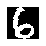

In [211]:
display(rr[0])

In [187]:
lolletje = X_test.to_numpy()
lolletje

array([array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),
       array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False]]),
       array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, Fa

In [164]:
from keras.datasets import mnist
#download mnist data and split into train and test sets
(X_train2, y_train2), (X_test2, y_test2) = mnist.load_data()

In [185]:
numpy.set_printoptions(threshold=10)

In [186]:
X_train2

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 